In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score

In [2]:
train = pd.read_csv('../data/processed_train.csv')
test = pd.read_csv('../data/processed_test.csv')


In [3]:
def tfidf_vectorizer(train, test):
    vec = TfidfVectorizer(max_features=10000)
    x_train = vec.fit_transform(train['text'])
    x_test = vec.transform(test['text'])
    return x_train, x_test

def bow_vectorizer(train, test):
    vec = CountVectorizer(max_features=10000)
    x_train = vec.fit_transform(train['text'])
    x_test = vec.transform(test['text'])
    return x_train, x_test

def binary_vectorizer(train, test):
    vec = CountVectorizer(binary=True, max_features=10000)
    x_train = vec.fit_transform(train['text'])
    x_test = vec.transform(test['text'])
    return x_train, x_test

In [4]:
def map_labels(y_true, y_pred):
    from scipy.stats import mode
    labels = np.zeros_like(y_pred)
    for i in range(3):
        mask = (y_pred == i)
        if np.any(mask):
            labels[mask] = mode(y_true[mask])[0]
    return labels


In [5]:
param_grid = {
    'n_clusters': [3],  # bạn có thể thử [2, 3, 4] nếu muốn
    'init': ['k-means++', 'random'],
    'n_init': [5, 10, 20],
    'max_iter': [500, 750, 1000]
}

vectorizers = {
    "TF-IDF": tfidf_vectorizer,
    "Bag of Words": bow_vectorizer,
    "Binary": binary_vectorizer
}

In [6]:
for vec_name, vectorizer in vectorizers.items():
    print(f"\n==== {vec_name} ====")
    x_train, x_test = vectorizer(train, test)
    y_train = train['sentiment'].values
    y_test = test['sentiment'].values

    best_f1 = 0
    best_params = None

    for params in ParameterGrid(param_grid):
        model = KMeans(**params, random_state=42)
        model.fit(x_train)
        y_pred = model.predict(x_test)
        mapped_pred = map_labels(y_test, y_pred)
        f1 = f1_score(y_test, mapped_pred, average='weighted')
        print(f"Params: {params} | F1-score: {f1:.4f}")
        if f1 > best_f1:
            best_f1 = f1
            best_params = params

    print(f"\nBest params for {vec_name}: {best_params} with F1-score: {best_f1:.4f}")


==== TF-IDF ====
Params: {'init': 'k-means++', 'max_iter': 500, 'n_clusters': 3, 'n_init': 5} | F1-score: 0.3294
Params: {'init': 'k-means++', 'max_iter': 500, 'n_clusters': 3, 'n_init': 10} | F1-score: 0.3294
Params: {'init': 'k-means++', 'max_iter': 500, 'n_clusters': 3, 'n_init': 20} | F1-score: 0.3294
Params: {'init': 'k-means++', 'max_iter': 750, 'n_clusters': 3, 'n_init': 5} | F1-score: 0.3294
Params: {'init': 'k-means++', 'max_iter': 750, 'n_clusters': 3, 'n_init': 10} | F1-score: 0.3294
Params: {'init': 'k-means++', 'max_iter': 750, 'n_clusters': 3, 'n_init': 20} | F1-score: 0.3294
Params: {'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 3, 'n_init': 5} | F1-score: 0.3294
Params: {'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 3, 'n_init': 10} | F1-score: 0.3294
Params: {'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 3, 'n_init': 20} | F1-score: 0.3294
Params: {'init': 'random', 'max_iter': 500, 'n_clusters': 3, 'n_init': 5} | F1-score: 0.2715
Params: {'init':

In [7]:
def model_eval_kmeans(y_true, y_pred):
    from scipy.stats import mode
    labels = np.zeros_like(y_pred)
    for i in range(3):  # 3 cụm
        mask = (y_pred == i)
        if np.any(mask):
            labels[mask] = mode(y_true[mask])[0]
    print(f'Accuracy Score: {accuracy_score(y_true, labels):.4f}')
    print('Classification Report:')
    print(classification_report(y_true, labels))
    print('Confusion Matrix:')
    cm = confusion_matrix(y_true, labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Neutral', 'Positive'], 
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

In [8]:
def run_kmeans(vectorizer_func, train, test, vectorizer_name):
    print(f"\n==== {vectorizer_name} Vectorization ====")
    x_train, x_test = vectorizer_func(train, test)
    y_train = train['sentiment'].values
    y_test = test['sentiment'].values
    model = KMeans(n_clusters=3, random_state=42, n_init=10)
    model.fit(x_train)
    y_pred = model.predict(x_test)
    model_eval_kmeans(y_test, y_pred)


==== TF-IDF Vectorization ====


Accuracy Score: 0.4465
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.42      0.96      0.59      1418
           2       0.72      0.19      0.30      1103

    accuracy                           0.45      3521
   macro avg       0.38      0.38      0.29      3521
weighted avg       0.39      0.45      0.33      3521

Confusion Matrix:


/home/ducanh/Credit/Comment-Sentiment-Analysis/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ducanh/Credit/Comment-Sentiment-Analysis/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ducanh/Credit/Comment-Sentiment-Analysis/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

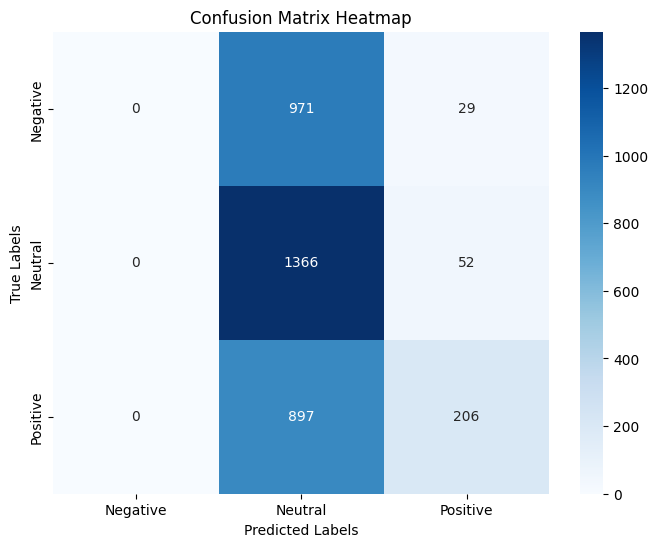


==== Bag of Words Vectorization ====
Accuracy Score: 0.4240
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.41      0.93      0.57      1418
           2       0.52      0.16      0.25      1103

    accuracy                           0.42      3521
   macro avg       0.31      0.36      0.27      3521
weighted avg       0.33      0.42      0.31      3521

Confusion Matrix:


/home/ducanh/Credit/Comment-Sentiment-Analysis/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ducanh/Credit/Comment-Sentiment-Analysis/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ducanh/Credit/Comment-Sentiment-Analysis/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

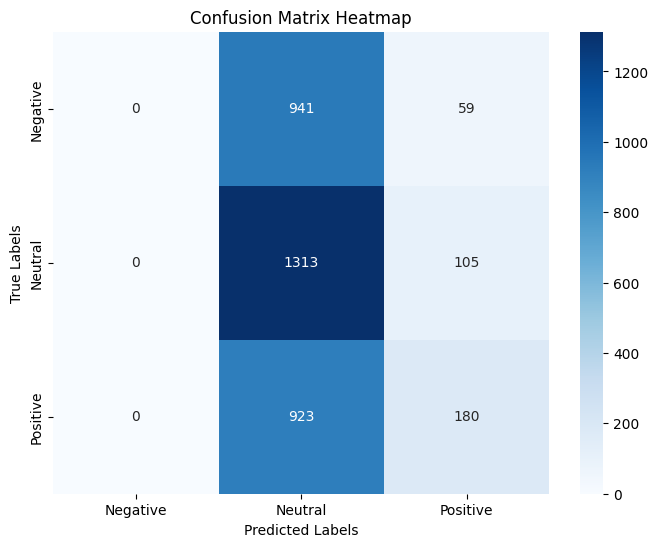


==== Binary Vectorization ====
Accuracy Score: 0.4220
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.41      0.95      0.57      1418
           2       0.56      0.12      0.20      1103

    accuracy                           0.42      3521
   macro avg       0.33      0.36      0.26      3521
weighted avg       0.34      0.42      0.30      3521

Confusion Matrix:


/home/ducanh/Credit/Comment-Sentiment-Analysis/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ducanh/Credit/Comment-Sentiment-Analysis/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ducanh/Credit/Comment-Sentiment-Analysis/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

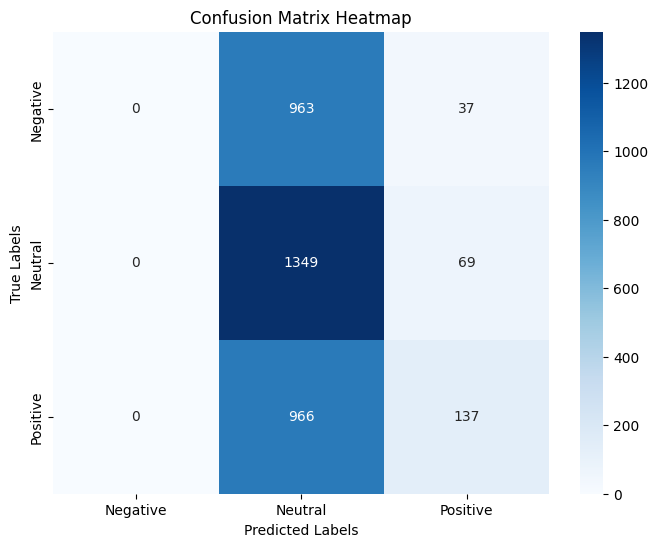

In [9]:
run_kmeans(tfidf_vectorizer, train, test, "TF-IDF")
run_kmeans(bow_vectorizer, train, test, "Bag of Words")
run_kmeans(binary_vectorizer, train, test, "Binary")